# Autoencoders: From linear to non-linear

#### Alexei Stepanenko

Many forms of high-dimensional data, such as images and audio, are heuristically known to concentrate near lower-dimensional "manifolds". Consider for instance the MNIST dataset which consists of 28 by 28 pixel grayscale images of handwritten digits. The datapoints are elements of the space $\mathbb{R}^{784}$, or more precisely $[0,1]^{784}$, where each components specifies the brightness of a given pixel. A random point in $[0,1]^{784}$ corresponds to an image of noise, nothing like any sort of handwritten digit. Therefore, the space of images of handwritten digits must be very restricted subset. 

To see that this subset should have some sort of continuous manifold-like structure, consider translating or rotating a handwritten digit a little. If we move a handwritten digit of the number "2" a few pixels to the right for instance, it's still a number "2". The spaces of translations and rotations are smooth manifolds, therefore the subset on which the data is concentrated inherits these properties.  

An *auto-encoder* is a model that is intended to learn lower-dimensional structures on which the dataset is concentrated. 
Fix a postive integer $N < 784$, the dimension of the lower-dimensional space. An auto-encoder is a model of the form
$$
F(x) = g(f(x)) 
$$
where $f:\mathbb{R}^{784} \to \mathbb{R}^N$ is the encoder and $g:\mathbb{R}^{N} \to \mathbb{R}^{784}$  is the decoder.
The encoder and decoder are learned functions - in this notebook, neural networks. 
The auto-encoder attempts to recover the data-points, there we
use a loss of the form 
$$
\mathcal{L}_{f,g}(x) = \frac{1}{2}\|x - g(f(x))\|^2
$$
where $\|\cdot\|$ is the Euclidean norm. For a given data-point $x$, $f(x)$ is often referred to as the *latent representation* and $\mathbb{R}^N$ is often referred to as the *latent space*. 

* [1 Principal Component Analysis](#PCA) We perform and visualise principal component analysis for MNIST.
* [2 Training non-linear auto-encoders](#train) We train a neural network based auto-encoder.
* [3 Comparison autoencoders vs. PCA](#comparison) We compare the approximation properties of PCA-based (linear) vs. neural-network-based auto-encoders for fixed $N$.
* [4 Interpolation in the latent space](#interpolation) We interpolate between different handwritten digits by pushing a path in  the latent space back into the image space.
* [5 Simple generative model](#generate) We train a simple generative model by fitting a probability distribution in the latent space.
* [Appendix PCA for single digit](#digit) We perform and visualise PCA for handwritten digits of "8".




<a id="PCA"></a>
## Principal Component Analysis

It can be show that Principal Component Analysis (https://en.wikipedia.org/wiki/Principal_component_analysis) is equivalent to a linear autoencoder (see the Deep Learning book of Goodfellow et. al.). In this case, the encoder is given by the projection onto the first $N$ principal components and the decoder is defined as a linear combination of these principal components. 

In this section, we perform and visualise principal component analysis for MNIST.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,  Lambda
from torchvision.io import read_image
from torch import nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
import os
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Importing MNIST dataset.

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 84435517.84it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36707786.01it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23481110.23it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 8169180.43it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Defining design matrix of flattened images and vector of targets.

In [3]:
data_train = DataLoader(training_data, batch_size = len(training_data))
X_Y = next(enumerate(data_train))[1]

In [4]:
X = X_Y[0]
X = torch.flatten(X, start_dim = 1) # Design matrix
Y = X_Y[1] # Vector of inputs
X = X.detach().numpy() # Converting to numpy arrays
Y = Y.detach().numpy()

Images may be recovered from the flattened data points as follows.

In [5]:
X[0].reshape(28,28);

### PCA for full dataset

We shall use `sklearn` to perform the principal component analysis. 

In [6]:
pca = PCA(n_components = 100)
pca.fit(X)

PCA(n_components=100)

Plotting the first 36 principal components.

In [7]:
eigvecs = pca.components_ # array of principal components

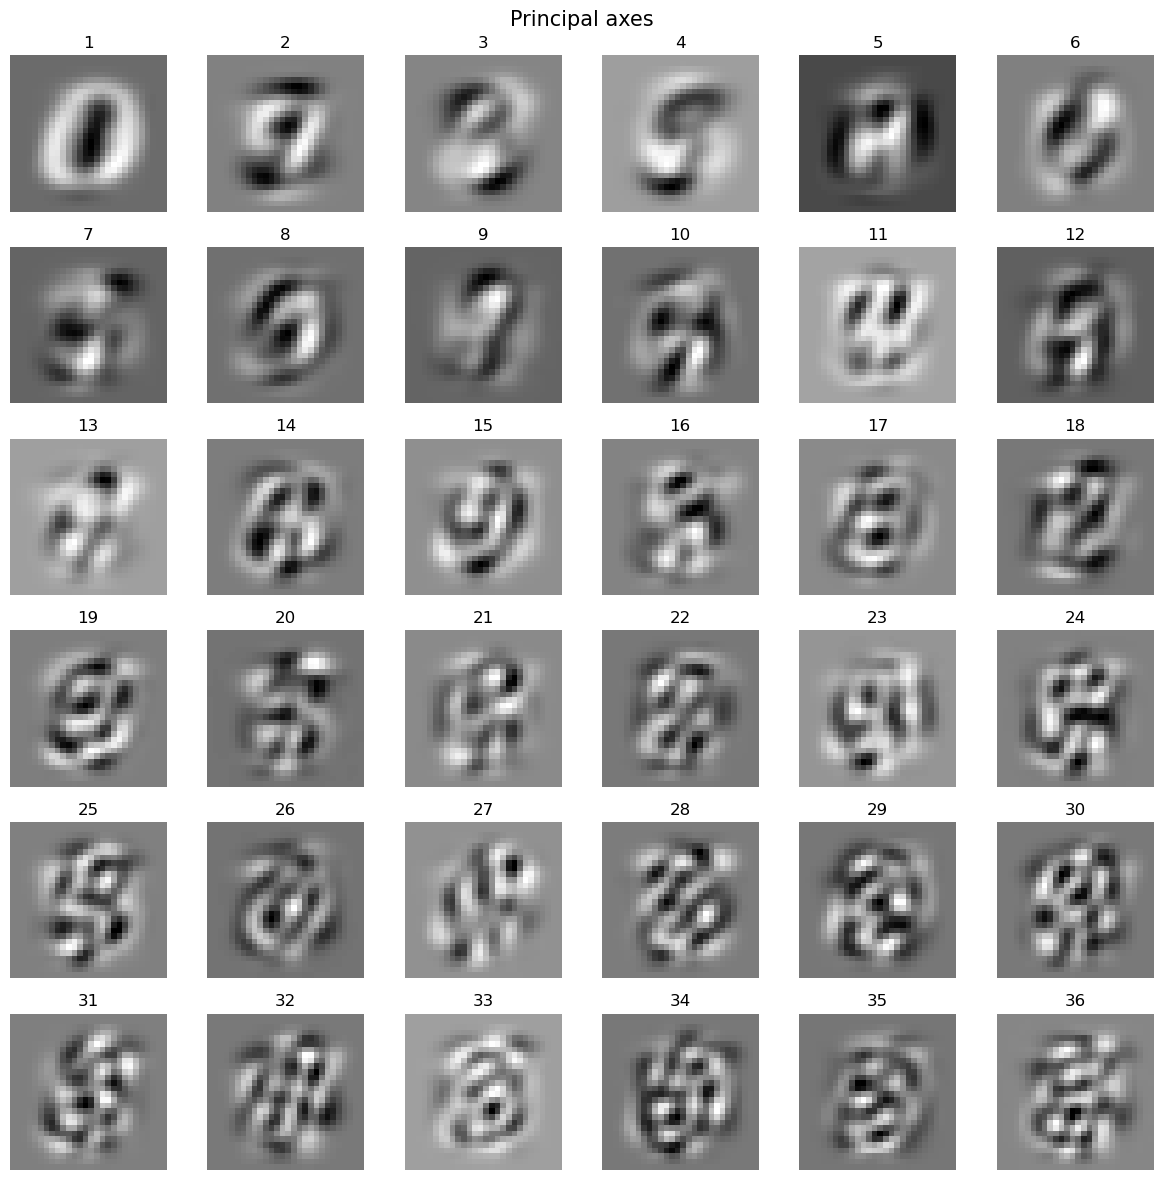

In [8]:
fig, ax = plt.subplots(6,6, figsize = (12,12))
for i in range(6):
    for j in range(6):
        ax[i,j].axis("off")
        ax[i,j].imshow(eigvecs[6*i + j].reshape(28,28), cmap = 'gray')
        ax[i,j].set_title(f"{6*i + j + 1}")
fig.suptitle("Principal axes", size = 15)
fig.tight_layout()


Plotting the projection of the MNIST datapoints along the first two principal axes. 

In [9]:
X_2 = np.matmul(X,eigvecs[:2].T) # Rows of X_2 are coords of datapoints along first two principal axes

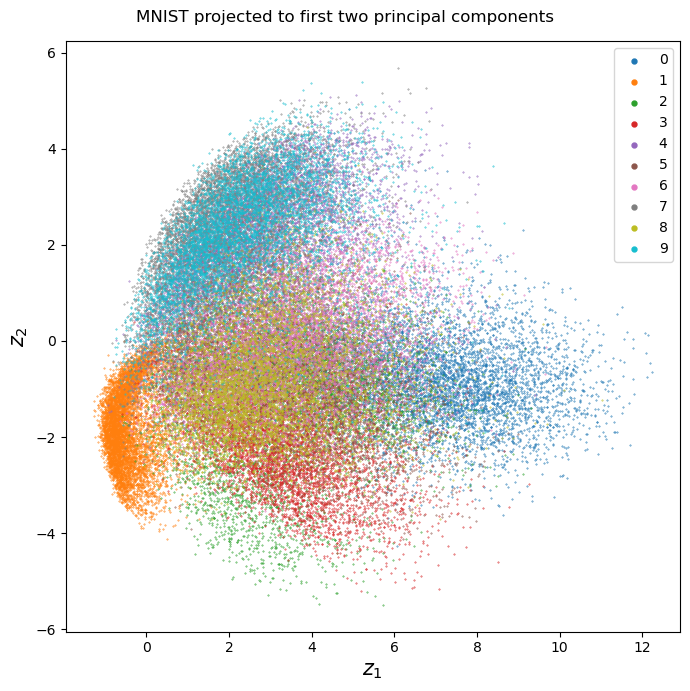

In [10]:
fig, ax = plt.subplots(1,1,figsize = (7,7))
for i in range(10):
    ind = [j for j in range(len(X_2)) if Y[j] == i]
    ax.scatter(X_2[ind].T[0],X_2[ind].T[1], marker = '.', s = 0.5, label = f'{i}')
ax.legend(markerscale = 10)
ax.set_xlabel(r'$z_1$',size = 15)
ax.set_ylabel(r'$z_2$',size = 15)
fig.suptitle('MNIST projected to first two principal components')
fig.tight_layout()
plt.show()

Visualising the projection of a datapoint onto different numbers of principal components. 

In [11]:
ind = 7
dp_col = X[ind].reshape(len(X[ind]),1) # A datapoint as a column vector
components = np.matmul(eigvecs,dp_col) # Inner product between datapoint and principal components
num_proj = [2,10,100] # Number of components for projections
comp_diag = np.diag(components.reshape(len(components))) # Diagonal matrix with components 
projs = np.matmul(comp_diag,eigvecs) # Projection of datapoint on individual principal components
proj_1 = np.sum(projs[0:num_proj[0]], axis = 0) # Projection of datapoint onto first `num_proj[i]` principal components
proj_2 = np.sum(projs[0:num_proj[1]], axis = 0)
proj_3 = np.sum(projs[0:num_proj[2]], axis = 0)
proj_1 = proj_1.reshape(28,28); proj_2 = proj_2.reshape(28,28); proj_3 = proj_3.reshape(28,28)
orig = dp_col.reshape(28,28) # Original image

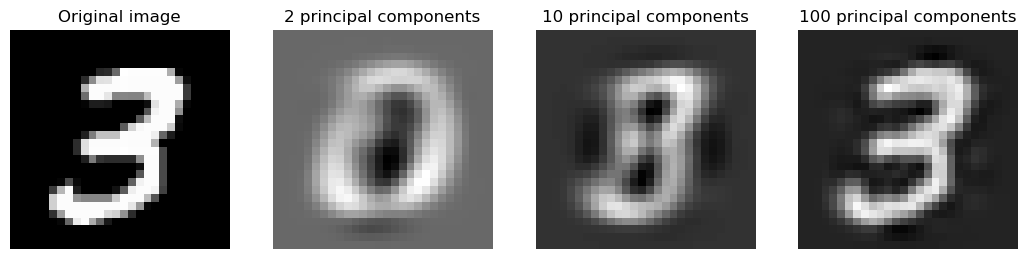

In [12]:
fig, ax = plt.subplots(1,4, figsize = (13,3))
ax[0].imshow(orig, cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Original image')
ax[1].imshow(proj_1, cmap = 'gray')
ax[1].axis('off')
ax[1].set_title(f'{num_proj[0]} principal components')
ax[2].imshow(proj_2, cmap = 'gray')
ax[2].axis('off')
ax[2].set_title(f'{num_proj[1]} principal components')
ax[3].imshow(proj_3, cmap = 'gray')
ax[3].axis('off')
ax[3].set_title(f'{num_proj[2]} principal components')
plt.show()

<a id="train"></a>
## Training non-linear autoencoders

### Code for autoencoder trainer

In [13]:
class AutoEnc_ReLU_flatten(nn.Module):
    '''
    Fully-connected deep autoencoder  with `d` (int) input features and a hidden code of dimension of `N` (int). 
    `enc_neuron_lst`: (list) widths of hidden layers for encoder neural network
    `dec_neuron_lst`: (list) widths of hidden layers for decoder neural network
    
    Input is flattened with `nn.Flatten(start_dim = 1)` such as to transform the input image dataset
    `[x_1,...,x_m]`, with each image `x_j` represented as a (1,n,n) tensor, to a dataset `[z_1,...,z_m]`, 
    where each `z_j` is a (n*n,) tensor.
    '''
    def __init__(self,d, N, enc_neuron_lst, dec_neuron_lst):
        super(AutoEnc_ReLU_flatten,self).__init__()
        self.flatten = nn.Flatten(start_dim = 1) # Don't flatten along first axis
        stack = nn.Sequential()
        enc_lst = enc_neuron_lst[:]
        enc_lst.insert(0,d)
        enc_lst.append(N)
        for i in range(len(enc_lst) - 2):
            stack.add_module(f'enc_lin_{i}', nn.Linear(enc_lst[i],enc_lst[i+1]))
            stack.add_module(f'enc_act_{i}', nn.ReLU())
        stack.add_module(f'enc_out', nn.Linear(enc_lst[len(enc_lst)-2],enc_lst[len(enc_lst)-1]))
        dec_lst = dec_neuron_lst[:]
        dec_lst.insert(0,N)
        dec_lst.append(d)
        for i in range(len(dec_lst) - 2):
            stack.add_module(f'dec_lin_{i}', nn.Linear(dec_lst[i],dec_lst[i+1]))
            stack.add_module(f'dec_act_{i}', nn.ReLU())
        stack.add_module(f'dec_out', nn.Linear(dec_lst[len(dec_lst)-2],dec_lst[len(dec_lst)-1]))
        self.stack = stack
        
    def forward(self,x):
        x = self.flatten(x)
        return self.stack(x)
    
def give_cost(loader, model, loss_fn):
    num_batch = 0
    cost = 0
    for X, y in loader:
        pred = model(X)
        X_flat = torch.flatten(X, start_dim = 1)
        cost += loss_fn(pred, X_flat)
        num_batch += 1
    cost = cost / num_batch
    return cost

class ex_autoencoder:

    def __init__(self,dataset,testset):
        self.dataset = dataset
        self.testset = testset
        # History lists (recording every epoch)
        self.Jtr_hist = [] # Training cost history 
        self.Jtst_hist = [] # Testing cost history 

    ### Parameters
    enc_neuron_lst = []
    dec_neuron_lst = []
    N = 2 
    # Learning parameters
    learning_rate = 0.1
    n_epochs = 50
    batch_size = 20 
    learning_rate = 0.1
    # Rate of printing
    n_print = 25 # Print after every `n_print` epochs
    
    
    # Model attribute
    model = None
    model_int = False # Has the model been previously initialised
    
        
    def go(self):
        dataset = self.dataset
        testset = self.testset
        learning_rate = self.learning_rate
        n_epochs = self.n_epochs
        batch_size = self.batch_size
        n_print = self.n_print
        enc_neuron_lst = self.enc_neuron_lst
        dec_neuron_lst = self.dec_neuron_lst
        model = self.model
        Jtr_hist = self.Jtr_hist 
        Jtst_hist = self.Jtst_hist
        
        # Specify training and testing dataloaders. 
        data_train = DataLoader(dataset, batch_size = batch_size)
        data_tst = DataLoader(testset, batch_size = len(testset))
        data_train_2 = DataLoader(dataset, batch_size = len(dataset))

        
        # Initiating optimiser
        if self.model_int == False:
            model = AutoEnc_ReLU_flatten(28*28,self.N,self.enc_neuron_lst,self.dec_neuron_lst) # MNIST images are 28x28, with 10 labels.
            self.model_int = True
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
       
        tr_err = None
        tst_err = None
        

        for t in range(n_epochs):
            Jtr_epoch = 0.0 # Training cost for epoch
            for batch, (X,y) in enumerate(data_train):
                # Compute prediction and loss
                pred = model(X)
                X_flat = torch.flatten(X, start_dim = 1)
                loss = loss_fn(pred, X_flat)
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Recording loss
                Jtr_epoch += loss.item()
            Jtr_epoch = Jtr_epoch/len(data_train)
            Jtr_hist.append(Jtr_epoch)
            tst_err = give_cost(data_tst, model, loss_fn).item()
            Jtst_hist.append(tst_err)

            # Printing every `n_print` epochs
            if t % n_print == 0:
                print(f"Epoch {t + 1}. Training cost: {Jtr_epoch:>6f}.")
                
        
        
        tr_err = give_cost(data_train, model, loss_fn).item(); tst_err = give_cost(data_tst, model, loss_fn).item()
        print(f"End. Training error: {tr_err:>6f}. Testing error: {tst_err:>6f}.")

         # Ring bell
        duration = 1  # seconds
        freq = 440  # Hz
        os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

        self.model = model
        self.Jtst_hist = Jtst_hist; self.Jtr_hist = Jtr_hist 
        self.tr_err = tr_err; self.tst_err = tst_err
        
    
    def plot_err(self):
        '''
        Plots training and testing error for evaluation
        '''
        plt.plot(np.linspace(1, len(self.Jtr_hist),len(self.Jtr_hist)), self.Jtr_hist, label = 'Batch training error')
        plt.plot(np.linspace(1, len(self.Jtst_hist),len(self.Jtst_hist)),self.Jtst_hist, label = 'Testing error')
        plt.plot([1,len(self.Jtr_hist)], [self.tr_err,self.tr_err], label = 'End training error', linestyle = '--')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

### Training the model

#### 100-dimensional code space - training

In [14]:
ex = ex_autoencoder(training_data,test_data)
ex.enc_neuron_lst = [300]
ex.dec_neuron_lst = [300]
ex.N = 100
# Learning parameters
ex.n_epochs = 50
ex.batch_size = 10
ex.learning_rate = 0.03
# Rate of printing
ex.n_print = 10 # Print after every `n_print` epochs

In [15]:
ex.go()

Epoch 1. Training cost: 0.072488.
Epoch 11. Training cost: 0.028160.
Epoch 21. Training cost: 0.020154.
Epoch 31. Training cost: 0.016191.
Epoch 41. Training cost: 0.014071.
End. Training error: 0.012788. Testing error: 0.012470.


sh: 1: play: not found


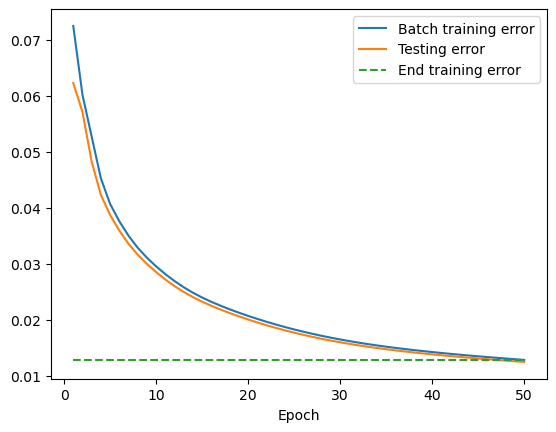

In [16]:
ex.plot_err()

Epoch 1. Training cost: 0.012716.
Epoch 11. Training cost: 0.011720.
Epoch 21. Training cost: 0.010950.
Epoch 31. Training cost: 0.010322.
Epoch 41. Training cost: 0.009805.
End. Training error: 0.009408. Testing error: 0.009170.


sh: 1: play: not found


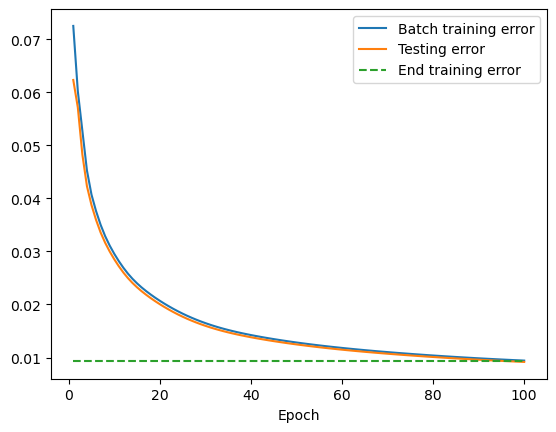

In [17]:
ex.go()
ex.plot_err()

Epoch 1. Training cost: 0.009382.
Epoch 11. Training cost: 0.009029.
Epoch 21. Training cost: 0.008725.
Epoch 31. Training cost: 0.008458.
Epoch 41. Training cost: 0.008217.
Epoch 51. Training cost: 0.007999.
Epoch 61. Training cost: 0.007803.
Epoch 71. Training cost: 0.007626.
Epoch 81. Training cost: 0.007466.
Epoch 91. Training cost: 0.007321.
Epoch 101. Training cost: 0.007190.
Epoch 111. Training cost: 0.007071.
Epoch 121. Training cost: 0.006965.
Epoch 131. Training cost: 0.006868.
Epoch 141. Training cost: 0.006782.
Epoch 151. Training cost: 0.006702.
Epoch 161. Training cost: 0.006629.
Epoch 171. Training cost: 0.006562.
Epoch 181. Training cost: 0.006498.
Epoch 191. Training cost: 0.006439.
End. Training error: 0.006387. Testing error: 0.006246.


sh: 1: play: not found


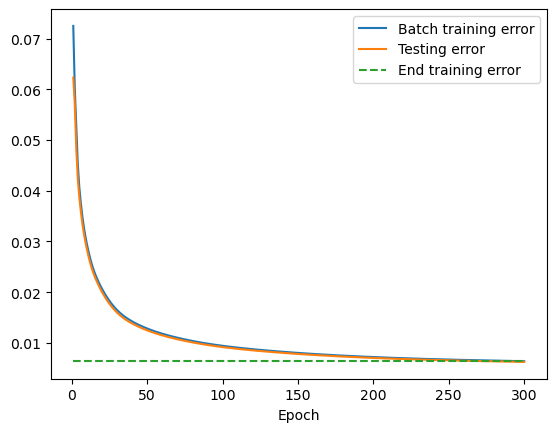

In [18]:
ex.n_epochs = 200
ex.go()
ex.plot_err()

Saving the model:

In [19]:
torch.save(ex.model.state_dict(), '/kaggle/working/full_300_100')

#### 100-dimensional code space - visualising

Loading back in the model 

In [20]:
ex = ex_autoencoder(training_data,test_data) 
# Resetting class hyperparameter attributes
ex.enc_neuron_lst = [300]
ex.dec_neuron_lst = [300]
ex.N = 100
ex.n_epochs = 50
ex.batch_size = 10
ex.learning_rate = 0.03
ex.n_print = 10 
# Loading model into attribute
ex.model = AutoEnc_ReLU_flatten(28*28,ex.N,ex.enc_neuron_lst,ex.dec_neuron_lst)
ex.model.load_state_dict(torch.load('/kaggle/working/full_300_100'))
ex.model_int = True


We recover the encoder and decoder from the autoencoder neural network as follows.

In [21]:
enc = nn.Sequential()
enc.add_module('enc_lin',nn.Linear(28*28,ex.enc_neuron_lst[0]))
enc.add_module('enc_act',nn.ReLU())
enc.add_module('enc_out',nn.Linear(ex.enc_neuron_lst[0],ex.N))
enc.enc_lin.weight = ex.model.stack.enc_lin_0.weight
enc.enc_lin.bias = ex.model.stack.enc_lin_0.bias
enc.enc_out.weight = ex.model.stack.enc_out.weight
enc.enc_out.bias = ex.model.stack.enc_out.bias
dec = nn.Sequential()
dec.add_module('dec_lin',nn.Linear(ex.N,ex.enc_neuron_lst[0]))
dec.add_module('dec_act',nn.ReLU())
dec.add_module('dec_out',nn.Linear(ex.enc_neuron_lst[0],28*28))
dec.dec_lin.weight = ex.model.stack.dec_lin_0.weight
dec.dec_lin.bias = ex.model.stack.dec_lin_0.bias
dec.dec_out.weight = ex.model.stack.dec_out.weight
dec.dec_out.bias = ex.model.stack.dec_out.bias

For a random datapoint $x$, we plot the hidden code $f_{\rm enc }(x)$ and the recovery $f_{\rm dec} \circ f_{\rm enc}(x)$ for the trained autoencoder $f_{\rm dec} \circ f_{\rm enc}$. 

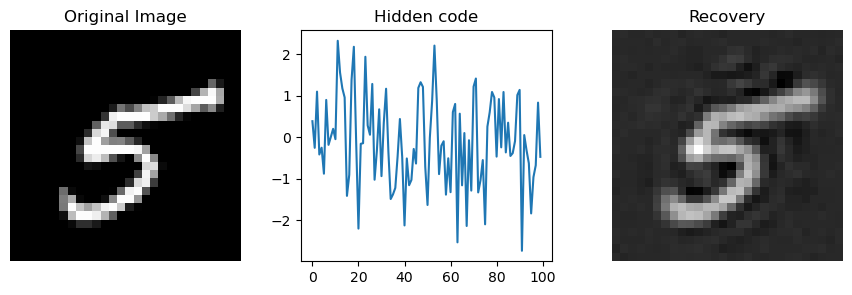

In [22]:
ind =  np.random.randint(0, len(training_data))
datapoint = training_data[ind][0]
datapoint = torch.flatten(datapoint, start_dim = 1)
recovery = ex.model(datapoint).reshape(28,28)
code = enc(datapoint)
code = torch.flatten(code).detach().numpy()
datapoint = datapoint.detach().numpy().reshape(28,28)
recovery = recovery.detach().numpy()
fig, ax  = plt.subplots(1,3, figsize = (11,3))
ax[0].imshow(datapoint, cmap = 'gray')
ax[0].axis("off")
ax[0].set_title("Original Image")
ax[1].plot(code)
ax[1].set_title("Hidden code")
ax[2].imshow(recovery, cmap = 'gray')
ax[2].axis("off")
ax[2].set_title("Recovery")
plt.show()

We may visualise the encoded data set $(f_{\rm enc}(x))_{x \in \rm{MNIST}}$ using its first two principal components.

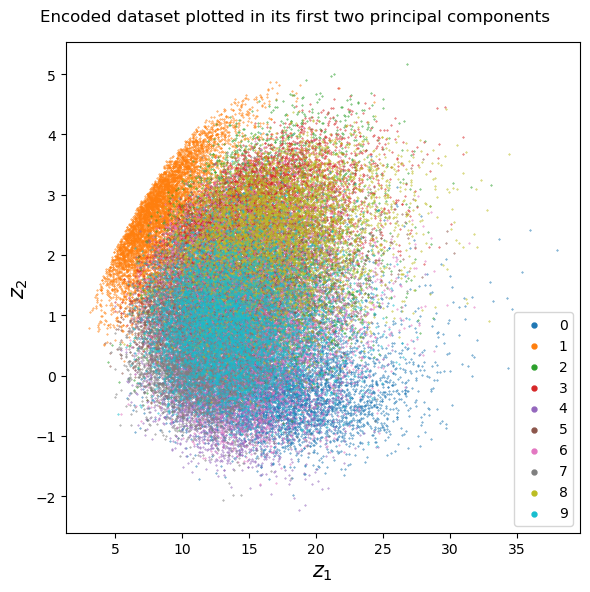

In [23]:
data_train = DataLoader(training_data, batch_size = len(training_data))
X_Y = next(enumerate(data_train))[1]
X = X_Y[0] # Inputs of dataset
X_enc = enc(torch.flatten(X,start_dim = 1)) # Encoded inputs
# Applying PCA to encoded inputs
X_enc = X_enc.detach().numpy()
pca_enc = PCA(n_components = 100)
pca_enc.fit(X_enc)
eigvecs_enc = pca_enc.components_ # array of principal components
X_enc_2 = np.matmul(X_enc,eigvecs_enc[:2].T) # Rows of X_2 are coords of datapoints along first two principal axes
# Plotting
fig, ax = plt.subplots(1,1,figsize = (6,6))
for i in range(10):
    ind = [j for j in range(len(X_enc_2)) if Y[j] == i]
    ax.scatter(X_enc_2[ind].T[0],X_enc_2[ind].T[1], marker = '.', s = 0.5, label = f'{i}')
ax.legend(markerscale = 10)
ax.set_xlabel(r'$z_1$',size = 15)
ax.set_ylabel(r'$z_2$',size = 15)
fig.suptitle('Encoded dataset plotted in its first two principal components')
fig.tight_layout()
plt.show()

#### 10-dimensional code space - training

In [24]:
ex = ex_autoencoder(training_data,test_data)
ex.enc_neuron_lst = [300,100]
ex.dec_neuron_lst = [300,100]
ex.N = 10
# Learning parameters
ex.n_epochs = 10
ex.batch_size = 10
ex.learning_rate = 0.03
# Rate of printing
ex.n_print = 10 # Print after every `n_print` epochs

In [25]:
ex.go()

Epoch 1. Training cost: 0.084737.
End. Training error: 0.052726. Testing error: 0.052350.


sh: 1: play: not found


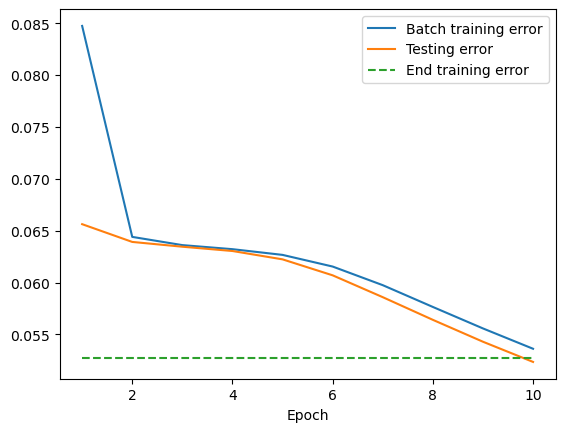

In [26]:
ex.plot_err()

In [27]:
ex.n_epochs = 300
ex.go()

Epoch 1. Training cost: 0.051800.
Epoch 11. Training cost: 0.039670.
Epoch 21. Training cost: 0.036562.
Epoch 31. Training cost: 0.034275.
Epoch 41. Training cost: 0.032961.
Epoch 51. Training cost: 0.031813.
Epoch 61. Training cost: 0.030692.
Epoch 71. Training cost: 0.029682.
Epoch 81. Training cost: 0.028796.
Epoch 91. Training cost: 0.028022.
Epoch 101. Training cost: 0.027351.
Epoch 111. Training cost: 0.026764.
Epoch 121. Training cost: 0.026242.
Epoch 131. Training cost: 0.025771.
Epoch 141. Training cost: 0.025342.
Epoch 151. Training cost: 0.024949.
Epoch 161. Training cost: 0.024588.
Epoch 171. Training cost: 0.024256.
Epoch 181. Training cost: 0.023952.
Epoch 191. Training cost: 0.023671.
Epoch 201. Training cost: 0.023410.
Epoch 211. Training cost: 0.023166.
Epoch 221. Training cost: 0.022936.
Epoch 231. Training cost: 0.022718.
Epoch 241. Training cost: 0.022510.
Epoch 251. Training cost: 0.022311.
Epoch 261. Training cost: 0.022121.
Epoch 271. Training cost: 0.021939.
Epo

sh: 1: play: not found


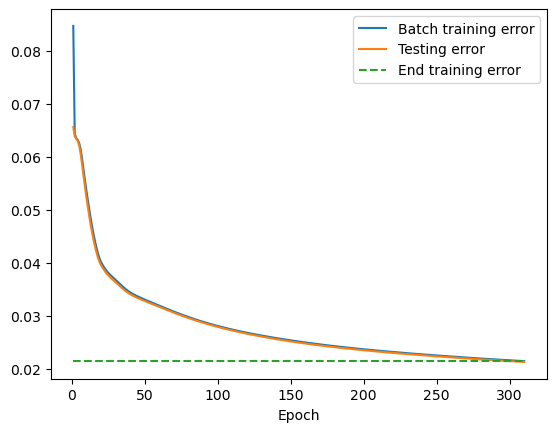

In [28]:
ex.plot_err()

Saving the model:

In [29]:
torch.save(ex.model.state_dict(), '/kaggle/working/full_300_100_10')

#### 10-dimensional code space - visualising

Loading back in the model 

In [30]:
ex = ex_autoencoder(training_data,test_data)
ex.enc_neuron_lst = [300,100]
ex.dec_neuron_lst = [300,100]
ex.N = 10
ex.n_epochs = 10
ex.batch_size = 10
ex.learning_rate = 0.03
ex.n_print = 10 # Print after every `n_print` epochs
ex.model = AutoEnc_ReLU_flatten(28*28,ex.N,ex.enc_neuron_lst,ex.dec_neuron_lst)
ex.model.load_state_dict(torch.load('/kaggle/working/full_300_100_10'))
ex.model_int = True

Recovering encoders and decoders.

In [31]:
enc = nn.Sequential()
enc_lst = ex.enc_neuron_lst
enc.add_module(f'enc_lin_0',nn.Linear(28*28,enc_lst[0]))
enc.add_module(f'enc_act_0',nn.ReLU())
enc.add_module(f'enc_lin_1',nn.Linear(enc_lst[0],enc_lst[1]))
enc.add_module(f'enc_act_1',nn.ReLU())
enc.add_module('enc_out',nn.Linear(enc_lst[1],ex.N))
enc.enc_lin_0.weight = ex.model.stack.enc_lin_0.weight
enc.enc_lin_0.bias = ex.model.stack.enc_lin_0.bias
enc.enc_lin_1.weight = ex.model.stack.enc_lin_1.weight
enc.enc_lin_1.bias = ex.model.stack.enc_lin_1.bias
enc.enc_out.weight = ex.model.stack.enc_out.weight
enc.enc_out.bias = ex.model.stack.enc_out.bias
dec = nn.Sequential()
dec_lst = ex.dec_neuron_lst
dec.add_module(f'dec_lin_0',nn.Linear(ex.N,dec_lst[0]))
dec.add_module(f'dec_act_0',nn.ReLU())
dec.add_module(f'dec_lin_1',nn.Linear(dec_lst[0],dec_lst[1]))
dec.add_module(f'dec_act_1',nn.ReLU())
dec.add_module('dec_out',nn.Linear(dec_lst[1],28*28))
dec.dec_lin_0.weight = ex.model.stack.dec_lin_0.weight
dec.dec_lin_0.bias = ex.model.stack.dec_lin_0.bias
dec.dec_lin_1.weight = ex.model.stack.dec_lin_1.weight
dec.dec_lin_1.bias = ex.model.stack.dec_lin_1.bias
dec.dec_out.weight = ex.model.stack.dec_out.weight
dec.dec_out.bias = ex.model.stack.dec_out.bias

For a random datapoint $x$, we plot the hidden code $f_{\rm enc }(x)$ and the recovery $f_{\rm dec} \circ f_{\rm enc}(x)$ for the trained autoencoder $f_{\rm dec} \circ f_{\rm enc}$. 

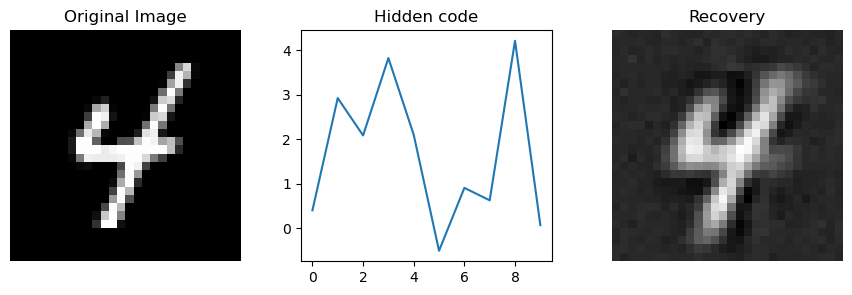

In [32]:
ind =  np.random.randint(0, len(training_data))
datapoint = training_data[ind][0]
datapoint = torch.flatten(datapoint, start_dim = 1)
recovery = ex.model(datapoint).reshape(28,28)
code = enc(datapoint)
code = torch.flatten(code).detach().numpy()
datapoint = datapoint.detach().numpy().reshape(28,28)
recovery = recovery.detach().numpy()
fig, ax  = plt.subplots(1,3, figsize = (11,3))
ax[0].imshow(datapoint, cmap = 'gray')
ax[0].axis("off")
ax[0].set_title("Original Image")
ax[1].plot(code)
ax[1].set_title("Hidden code")
ax[2].imshow(recovery, cmap = 'gray')
ax[2].axis("off")
ax[2].set_title("Recovery")
plt.show()

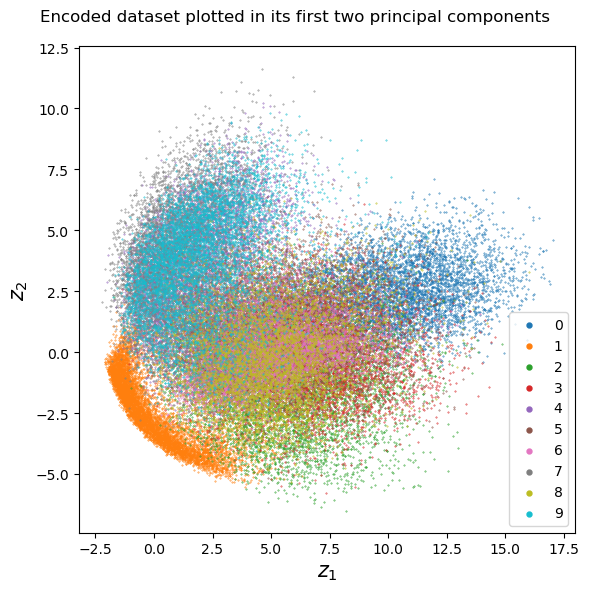

In [33]:
data_train = DataLoader(training_data, batch_size = len(training_data))
X_Y = next(enumerate(data_train))[1]
X = X_Y[0] # Inputs of dataset
X_enc = enc(torch.flatten(X,start_dim = 1)) # Encoded inputs
eigvecs_enc = pca_enc.components_ # array of principal components 
# Applying PCA to encoded inputs
X_enc = X_enc.detach().numpy()
pca_enc = PCA(n_components = 10)
pca_enc.fit(X_enc)
eigvecs_enc = pca_enc.components_ # array of principal components
X_enc_2 = np.matmul(X_enc,eigvecs_enc[:2].T) # Rows of X_2 are coords of datapoints along first two principal axes
# Plotting
fig, ax = plt.subplots(1,1,figsize = (6,6))
for i in range(10):
    ind = [j for j in range(len(X_enc_2)) if Y[j] == i]
    ax.scatter(X_enc_2[ind].T[0],X_enc_2[ind].T[1], marker = '.', s = 0.5, label = f'{i}')
ax.legend(markerscale = 10)
ax.set_xlabel(r'$z_1$',size = 15)
ax.set_ylabel(r'$z_2$',size = 15)
fig.suptitle('Encoded dataset plotted in its first two principal components')
fig.tight_layout()
plt.show()

<a id="comparison"></a>
## Comparison autoencoders vs. PCA

#### Preliminary code

Loading in autoencoder models (`ex1`: 100-d code space, `ex2`: 10-d code space) and recovering respective encoders (`enc1` and `enc2`) and decoders (`dec1` and `dec2`).

In [34]:
ex1 = ex_autoencoder(training_data,test_data) 
ex1.enc_neuron_lst = [300]
ex1.dec_neuron_lst = [300]
ex1.N = 100
ex1.n_epochs = 50
ex1.batch_size = 10
ex1.learning_rate = 0.03
ex1.n_print = 10 
ex1.model = AutoEnc_ReLU_flatten(28*28,ex1.N,ex1.enc_neuron_lst,ex1.dec_neuron_lst)
ex1.model.load_state_dict(torch.load('full_300_100'))
ex1.model_int = True
ex2 = ex_autoencoder(training_data,test_data)
ex2.enc_neuron_lst = [300,100]
ex2.dec_neuron_lst = [300,100]
ex2.N = 10
ex2.n_epochs = 10
ex2.batch_size = 10
ex2.learning_rate = 0.03
ex2.n_print = 10 # Print after every `n_print` epochs
ex2.model = AutoEnc_ReLU_flatten(28*28,ex2.N,ex2.enc_neuron_lst,ex2.dec_neuron_lst)
ex2.model.load_state_dict(torch.load('/kaggle/working/full_300_100_10'))
ex2.model_int = True


In [35]:
enc1 = nn.Sequential()
enc1.add_module('enc_lin',nn.Linear(28*28,ex1.enc_neuron_lst[0]))
enc1.add_module('enc_act',nn.ReLU())
enc1.add_module('enc_out',nn.Linear(ex1.enc_neuron_lst[0],ex1.N))
enc1.enc_lin.weight = ex1.model.stack.enc_lin_0.weight
enc1.enc_lin.bias = ex1.model.stack.enc_lin_0.bias
enc1.enc_out.weight = ex1.model.stack.enc_out.weight
enc1.enc_out.bias = ex1.model.stack.enc_out.bias
dec1 = nn.Sequential()
dec1.add_module('dec_lin',nn.Linear(ex1.N,ex1.dec_neuron_lst[0]))
dec1.add_module('dec_act',nn.ReLU())
dec1.add_module('dec_out',nn.Linear(ex1.dec_neuron_lst[0],28*28))
dec1.dec_lin.weight = ex1.model.stack.dec_lin_0.weight
dec1.dec_lin.bias = ex1.model.stack.dec_lin_0.bias
dec1.dec_out.weight = ex1.model.stack.dec_out.weight
dec1.dec_out.bias = ex1.model.stack.dec_out.bias
enc2 = nn.Sequential()
enc2_lst = ex2.enc_neuron_lst
enc2.add_module(f'enc_lin_0',nn.Linear(28*28,enc2_lst[0]))
enc2.add_module(f'enc_act_0',nn.ReLU())
enc2.add_module(f'enc_lin_1',nn.Linear(enc2_lst[0],enc2_lst[1]))
enc2.add_module(f'enc_act_1',nn.ReLU())
enc2.add_module('enc_out',nn.Linear(enc2_lst[1],ex2.N))
enc2.enc_lin_0.weight = ex2.model.stack.enc_lin_0.weight
enc2.enc_lin_0.bias = ex2.model.stack.enc_lin_0.bias
enc2.enc_lin_1.weight = ex2.model.stack.enc_lin_1.weight
enc2.enc_lin_1.bias = ex2.model.stack.enc_lin_1.bias
enc2.enc_out.weight = ex2.model.stack.enc_out.weight
enc2.enc_out.bias = ex2.model.stack.enc_out.bias
dec2 = nn.Sequential()
dec2_lst = ex2.dec_neuron_lst
dec2.add_module(f'dec_lin_0',nn.Linear(ex2.N,dec2_lst[0]))
dec2.add_module(f'dec_act_0',nn.ReLU())
dec2.add_module(f'dec_lin_1',nn.Linear(dec2_lst[0],dec2_lst[1]))
dec2.add_module(f'dec_act_1',nn.ReLU())
dec2.add_module('dec_out',nn.Linear(dec2_lst[1],28*28))
dec2.dec_lin_0.weight = ex2.model.stack.dec_lin_0.weight
dec2.dec_lin_0.bias = ex2.model.stack.dec_lin_0.bias
dec2.dec_lin_1.weight = ex2.model.stack.dec_lin_1.weight
dec2.dec_lin_1.bias = ex2.model.stack.dec_lin_1.bias
dec2.dec_out.weight = ex2.model.stack.dec_out.weight
dec2.dec_out.bias = ex2.model.stack.dec_out.bias

Design matrix for MNIST:

In [36]:
data_train = DataLoader(training_data, batch_size = len(training_data))
X_Y = next(enumerate(data_train))[1]
X = X_Y[0] # Inputs of dataset

### Comparison of compression quality

In [37]:
# Computing principal components
X_np = torch.flatten(X, start_dim = 1).detach().numpy()
pca = PCA(n_components = 100)
pca.fit(X_np)
eigvecs = pca.components_ # array of principal components
# Projecting 
ind = 7
dp_col = X_np[ind].reshape(len(X_np[ind]),1) # A datapoint as a column vector
components = np.matmul(eigvecs,dp_col) # Inner product between datapoint and principal components
num_proj = [10,100] # Number of components for projections
comp_diag = np.diag(components.reshape(len(components))) # Diagonal matrix with components 
projs = np.matmul(comp_diag,eigvecs) # Projection of datapoint on individual principal components
proj_1 = np.sum(projs[0:num_proj[0]], axis = 0) # Projection of datapoint onto first `num_proj[i]` principal components
proj_2 = np.sum(projs[0:num_proj[1]], axis = 0)
proj_1 = proj_1.reshape(28,28); proj_2 = proj_2.reshape(28,28)
orig = dp_col.reshape(28,28) # Original image
# Computing autoencoder compression 
ex1_recover = ex1.model(X[ind]).reshape(28,28).detach().numpy()
ex2_recover = ex2.model(X[ind]).reshape(28,28).detach().numpy()

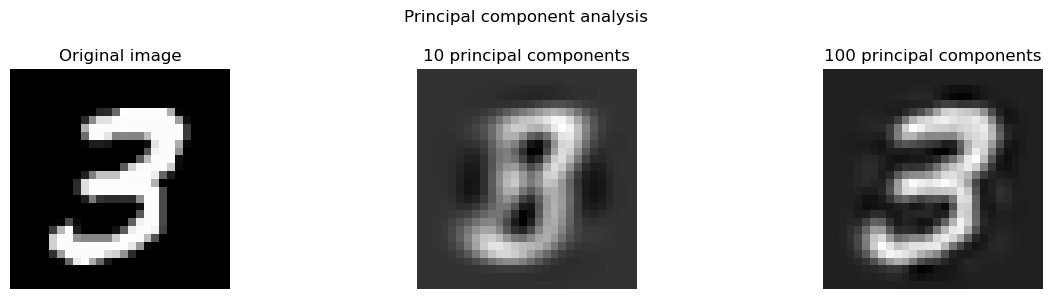

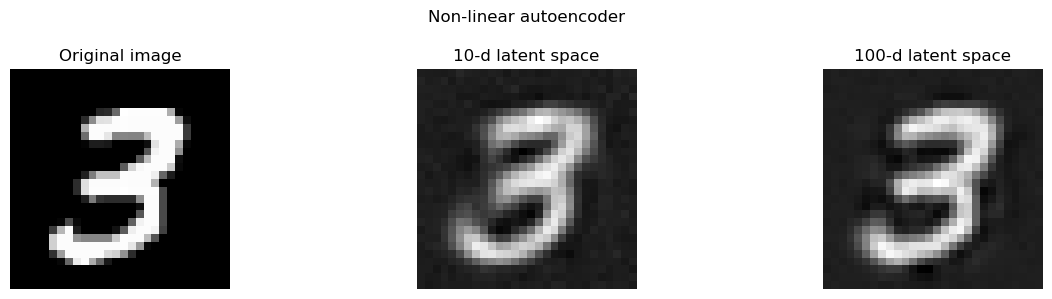

In [38]:
fig, ax = plt.subplots(1,3, figsize = (13,3))
ax[0].imshow(orig, cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Original image')
ax[1].imshow(proj_1, cmap = 'gray')
ax[1].axis('off')
ax[1].set_title(f'{num_proj[0]} principal components')
ax[2].imshow(proj_2, cmap = 'gray')
ax[2].axis('off')
ax[2].set_title(f'{num_proj[1]} principal components')
fig.suptitle('Principal component analysis')
fig.tight_layout()
plt.show()
fig, ax = plt.subplots(1,3, figsize = (13,3))
ax[0].imshow(orig, cmap = 'gray')
ax[0].axis('off')
ax[0].set_title('Original image')
ax[1].imshow(ex2_recover, cmap = 'gray')
ax[1].axis('off')
ax[1].set_title(f'{num_proj[0]}-d latent space')
ax[2].imshow(ex1_recover, cmap = 'gray')
ax[2].axis('off')
ax[2].set_title(f'{num_proj[1]}-d latent space')
fig.suptitle('Non-linear autoencoder')
fig.tight_layout()
plt.show()

<a id="interpolation"></a>
## Interpolation in the latent space

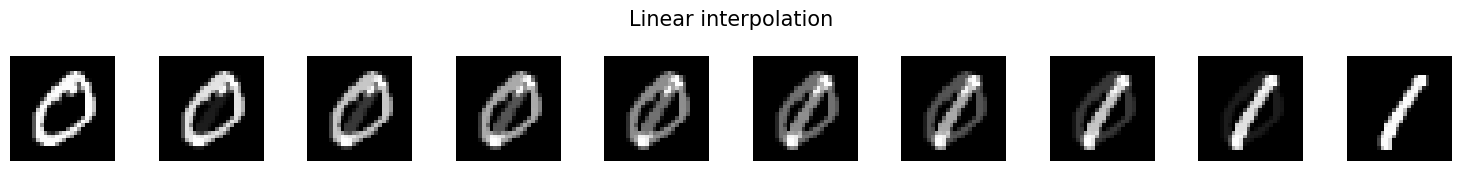

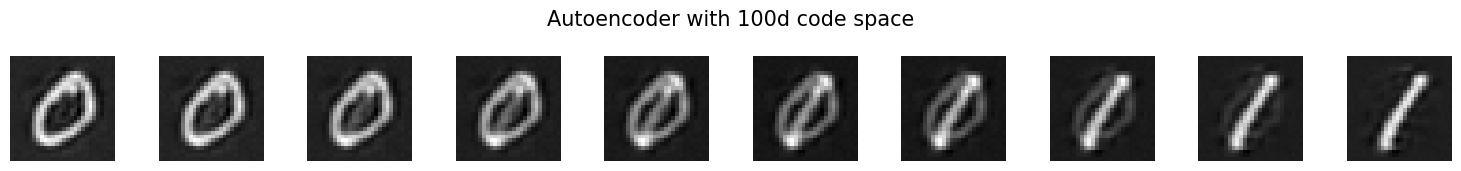

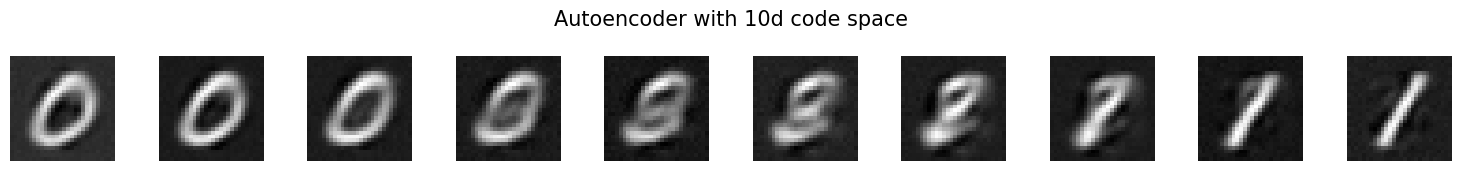

In [39]:
ind_1 = 1
ind_2 = 3
X_ind_1 = torch.flatten(X[ind_1],start_dim = 1)[0]
X_ind_2 = torch.flatten(X[ind_2],start_dim = 1)[0]
# Linear interpolation
path_1 = []
for t in np.linspace(0,1,10):
    path_1.append(t*X_ind_2 + (1 - t)*X_ind_1)
fig, ax = plt.subplots(1,10,figsize = (15,1.7))
for i in range(10):
    ax[i].imshow(path_1[i].detach().numpy().reshape(28,28),cmap = 'gray')
    ax[i].axis("off")
fig.suptitle('Linear interpolation',size = 15)
fig.tight_layout()
# Autoencoder 1
enc1_1 = enc1(X_ind_1)
enc1_2 = enc1(X_ind_2)
path_2 = []
for t in np.linspace(0,1,10):
    path_2.append(dec1(t*enc1_2 + (1 - t)*enc1_1))
fig, ax = plt.subplots(1,10,figsize = (15,1.7))
for i in range(10):
    ax[i].imshow(path_2[i].detach().numpy().reshape(28,28),cmap = 'gray')
    ax[i].axis("off")
fig.suptitle('Autoencoder with 100d code space',size = 15)
fig.tight_layout()
# Autoencoder 2
enc2_1 = enc2(X_ind_1)
enc2_2 = enc2(X_ind_2)
path_3 = []
for t in np.linspace(0,1,10):
    path_3.append(dec2(t*enc2_2 + (1 - t)*enc2_1))
fig, ax = plt.subplots(1,10,figsize = (15,1.7))
for i in range(10):
    ax[i].imshow(path_3[i].detach().numpy().reshape(28,28),cmap = 'gray')
    ax[i].axis("off")
fig.suptitle('Autoencoder with 10d code space',size = 15)
fig.tight_layout()

<a id="generate"></a>
## Simple generative model

We shall creat a simple generative model from the trained 10d autoencoder by the following procedure:
1. Fit 10 Gaussians $G_1,..., G_{10}$ to $(f_{\rm enc}(x))_{x \sim \rm MNIST}$
2. Generate examples by sampling $(f_{\rm dec}(h))_{h \sim G_1 \cup \cdots \cup G_{10}}$


In [40]:
enc_ds = enc2(torch.flatten(X,start_dim = 1)).detach().numpy() # Encoded dataset

In [41]:
GM = GaussianMixture(n_components = 10)

In [42]:
GM.fit(enc_ds)

GaussianMixture(n_components=10)

In [43]:
# The parameters of the fitted Gaussian mixture model can be accessed as follows
GM.weights_; GM.means_; GM.covariances_;

In [44]:
# ... and sampled as follows
GM.sample(n_samples = 1)

(array([[ 3.93840331,  1.65505029, -2.33728835,  7.86576141, -0.07382923,
          0.90360081,  1.31049494,  0.4272974 ,  4.83196464,  2.08698977]]),
 array([4]))

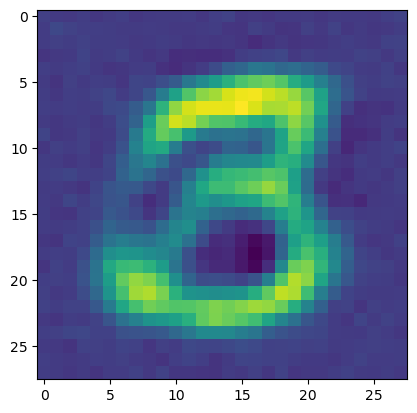

In [45]:
plt.imshow(dec2(torch.tensor(GM.sample(n_samples = 1)[0][0],dtype = torch.float32)).detach().numpy().reshape(28,28))

In [46]:
mu = np.zeros(10) 
cov = np.identity(10)
samp_lst = []
for i in range(36):
    samp_lst.append(multivariate_normal.rvs(mu,cov))
gen_lst = []
for i in range(36):
    gen_lst.append(dec2(torch.tensor(samp_lst[i], dtype = torch.float32)).detach().numpy())

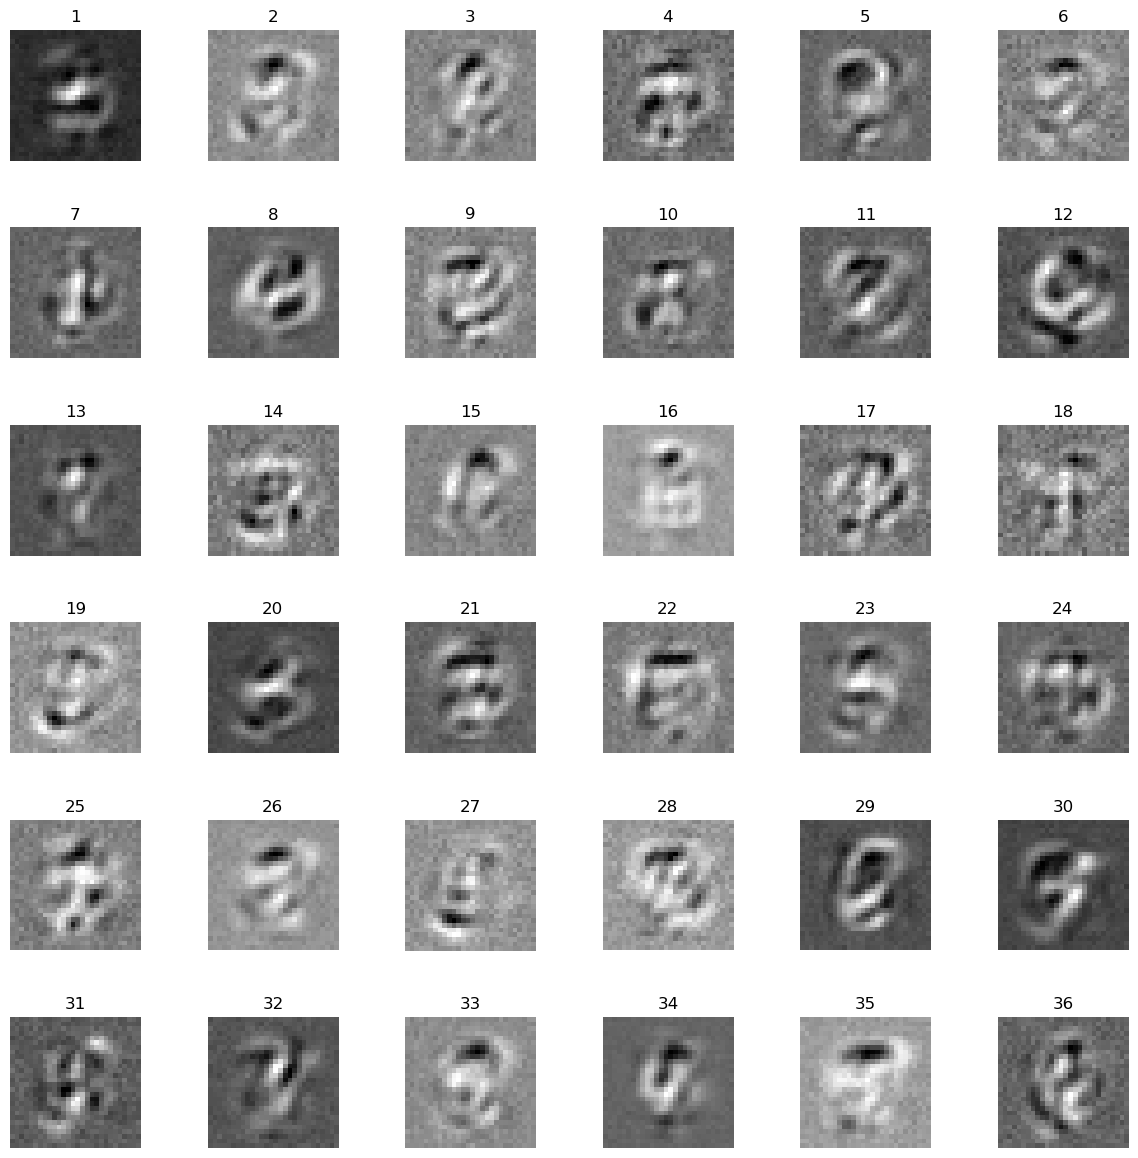

In [47]:
fig, ax = plt.subplots(6,6, figsize = (12,12))
fig.tight_layout()
for i in range(6):
    for j in range(6):
        ax[i,j].axis("off")
        ax[i,j].imshow(gen_lst[6*i + j].reshape(28,28), cmap = 'gray')
        ax[i,j].set_title(f"{6*i + j + 1}")

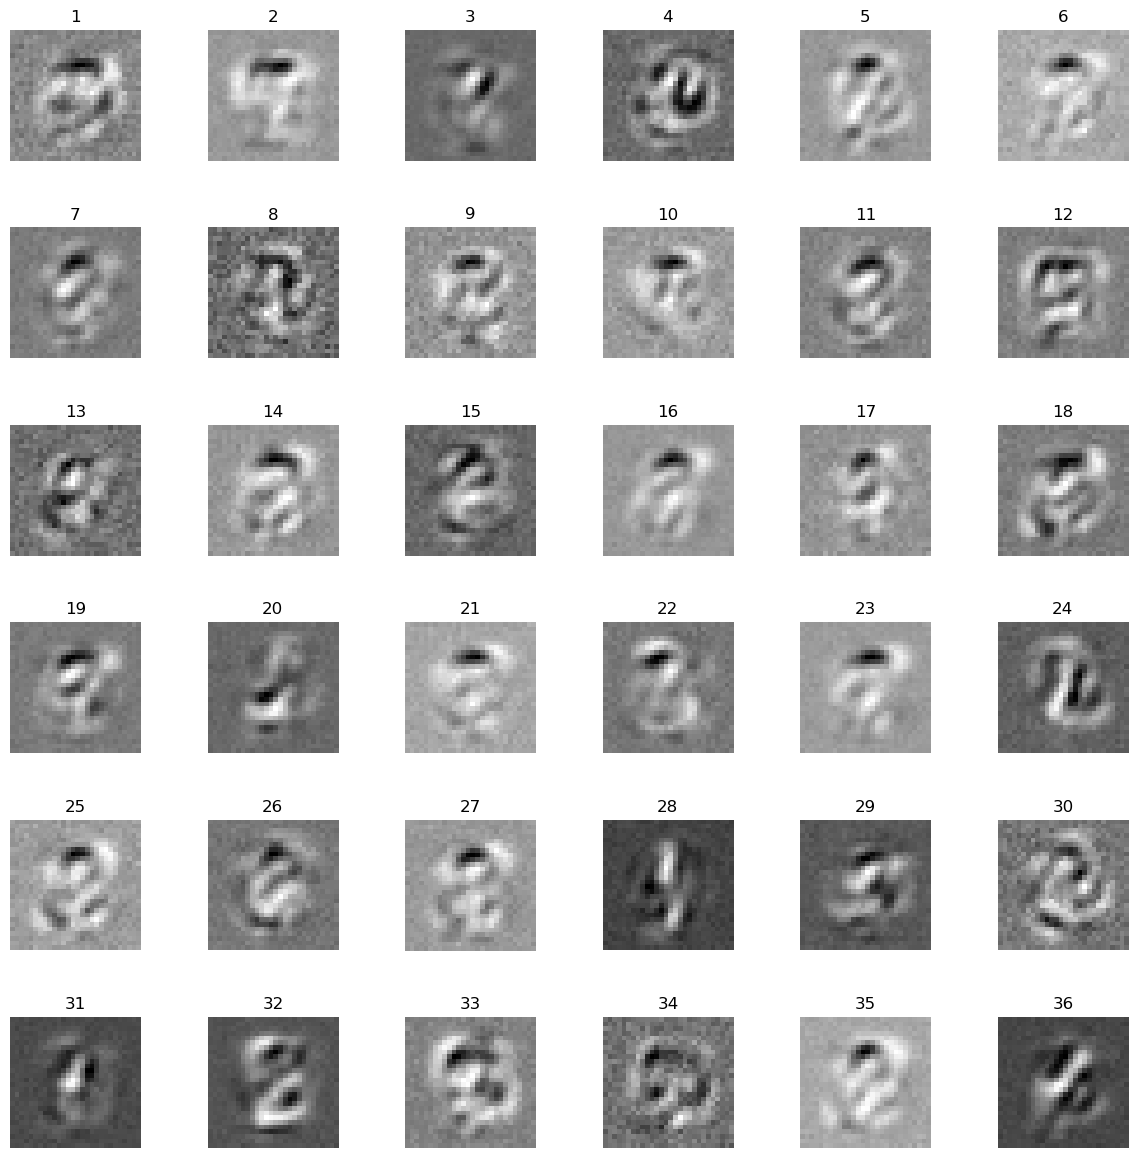

In [48]:
mu = np.random.normal(size = (10,)) 
cov = 4*np.identity(10)
samp_lst = []
for i in range(36):
    samp_lst.append(multivariate_normal.rvs(mu,cov))
gen_lst = []
for i in range(36):
    gen_lst.append(dec2(torch.tensor(samp_lst[i], dtype = torch.float32)).detach().numpy())
    
fig, ax = plt.subplots(6,6, figsize = (12,12))
fig.tight_layout()
for i in range(6):
    for j in range(6):
        ax[i,j].axis("off")
        ax[i,j].imshow(gen_lst[6*i + j].reshape(28,28), cmap = 'gray')
        ax[i,j].set_title(f"{6*i + j + 1}")

<a id="digit"></a>
## Appendix: PCA for single digit

In [49]:
data_train = DataLoader(training_data, batch_size = len(training_data))
X_Y = next(enumerate(data_train))[1]

In [50]:
X = X_Y[0]
X = torch.flatten(X, start_dim = 1) # Design matrix
Y = X_Y[1] # Vector of inputs
X = X.detach().numpy() # Converting to numpy arrays
Y = Y.detach().numpy()

In [51]:
ind_8 = [i for i in range(len(X)) if Y[i] == 8]
X_8 = X[ind_8] # Flattened MNIST images of 8's
pca_8 = PCA(n_components = 100)
pca_8.fit(X_8) # PCA for 8's
eigvecs_8 = pca_8.components_ # array of principal components

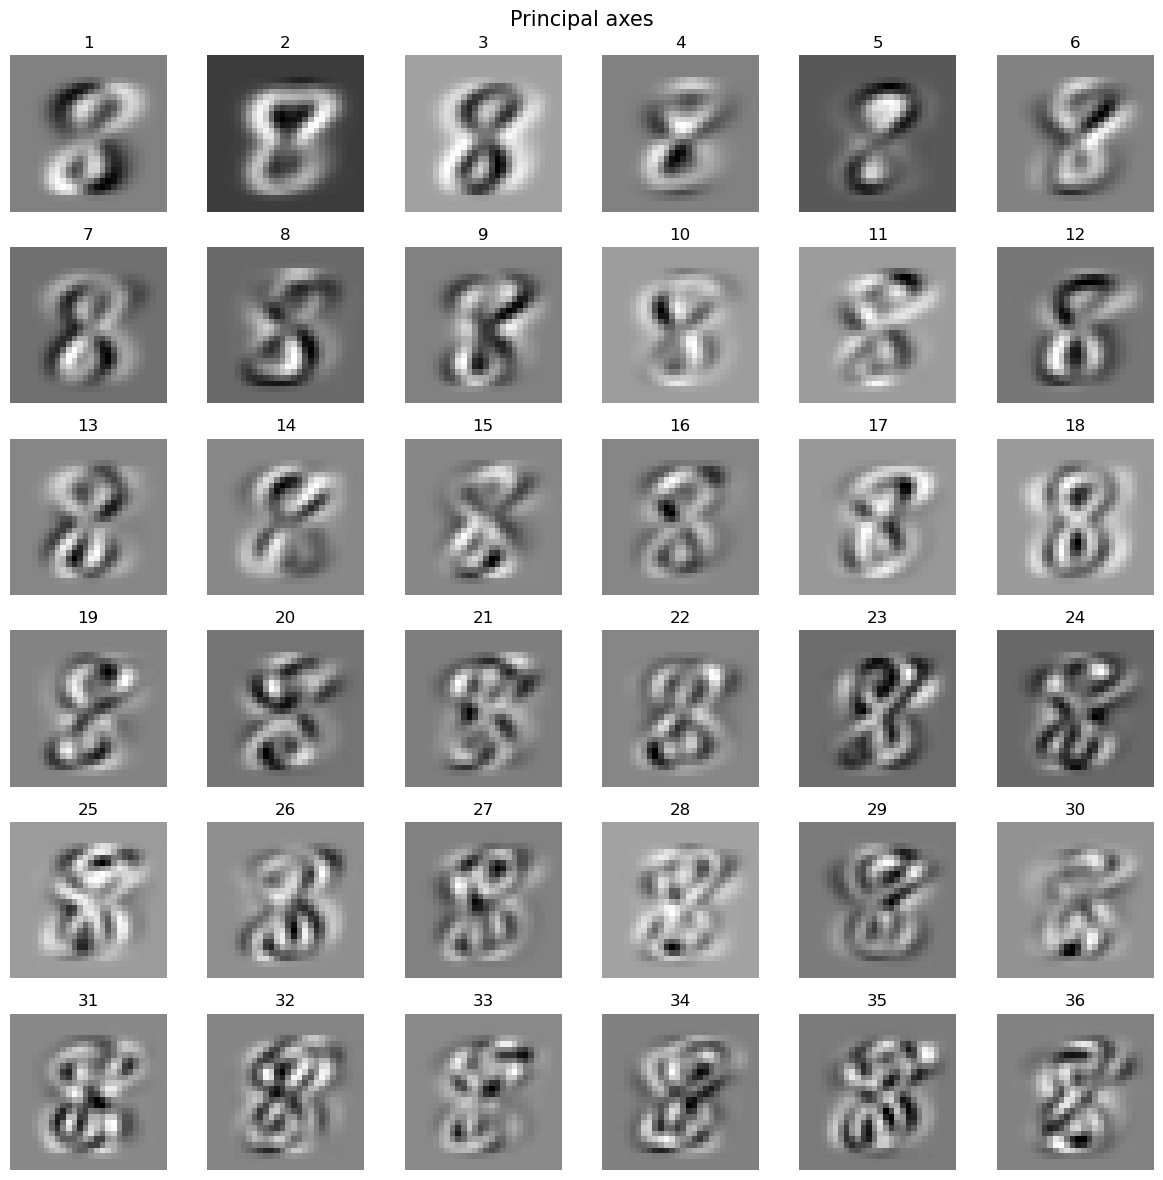

In [52]:
fig, ax = plt.subplots(6,6, figsize = (12,12))
for i in range(6):
    for j in range(6):
        ax[i,j].axis("off")
        ax[i,j].imshow(eigvecs_8[6*i + j].reshape(28,28), cmap = 'gray')
        ax[i,j].set_title(f"{6*i + j + 1}")
fig.suptitle("Principal axes", size = 15)
fig.tight_layout()

In [53]:
X_8_2 = np.matmul(X_8,eigvecs_8[:2].T) # Rows of X_2 are coords of 8s along first two principal axes

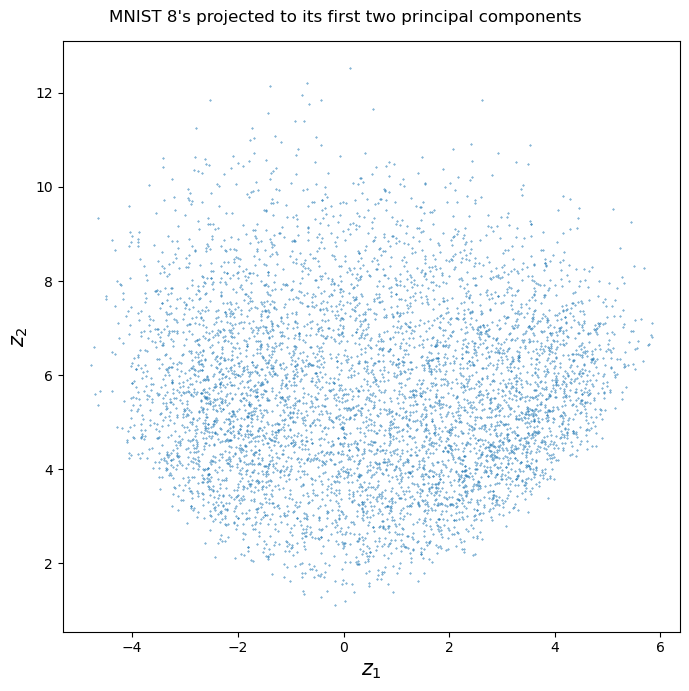

In [54]:
fig, ax = plt.subplots(1,1,figsize = (7,7))
ax.scatter(X_8_2.T[0],X_8_2.T[1], marker = '.', s = 0.5)
ax.set_xlabel(r'$z_1$',size = 15)
ax.set_ylabel(r'$z_2$',size = 15)
fig.suptitle('MNIST 8\'s projected to its first two principal components')
fig.tight_layout()
plt.show()